# Simple Wind/Solar/H2/Methanol Hybrid Plant Example
---
In this example, we will walk through the process of simulating a hybrid renewable energy system using the Hybrid Optimization Performance Platform ([HOPP](https://github.com/NREL/HOPP)) library. We will simulate a hybrid system at a given location consisting of both wind and solar electricity, sent to a hydrogen electrolyzer, whose hydrogen output is then sent to make methanol, and show how to access the simulation outputs.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [71]:
from hopp.simulation import HoppInterface
from hopp.simulation.technologies.hydrogen.electrolysis import run_h2_PEM
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from hopp.simulation.technologies.sites import SiteInfo, methanol_site
from hopp.utilities import load_yaml

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration. In this example, the yaml activates the "simple" financial model that has fewer, stripped-down inputs and outputs as compared to the PySAM model.

Within the YAML configuration, you have the flexibility to define the plant's location details and configure the associated technologies, in this case wind, solar wind, and a fuel plant that generates methanol from hydrogen and CO2.

In this example, we use the Flatirons site as a sample location and configure the wind and solar data for this particular site using pre-existing data files.

In [72]:
hi = HoppInterface("./inputs/08-wind-solar-electrolyzer-fuel.yaml")

hi.system.pv._system_model.SystemDesign.dc_ac_ratio = 1.28
hi.system.pv._system_model.SystemDesign.losses = 14.3

### Use the fuel plant to size the wind, solar, co2 source, and electrolyzer

Only the simple methanol reactor model will be run, to determine the hydrogen and co2 input needed, and in turn the electricity input needed to the electrolyzer, to size the wind, solar, and electrolyzer components.

In [73]:
# Run just the reactor model
hi.system.fuel.simulate_flow(1)
total_elec_kw = np.mean((hi.system.fuel._system_model.input_streams_kw['electricity']))

# Use the calculated co2 input flowrate to size the co2 source plant, switch off costs if using raw flue gas
co2_kg_s = np.mean(hi.system.fuel._system_model.input_streams_kg_s['carbon dioxide'])
getattr(hi.system,'co2').value('co2_kg_s',co2_kg_s)
if hi.system.tech_config.co2.capture_model == 'None':
    hi.system.co2._financial_model.voc_kg = 0.
    hi.system.tech_config.co2.lca['co2_kg_kg'] = 0.
    hi.system.ng._system_model.annual_mass_kg = 0.
hi.system.co2.simulate_flow(1)
ng_kg_s = np.mean(hi.system.co2._system_model.input_streams_kg_s['natural gas'])
hi.system.ng._system_model.ng_kg_s = ng_kg_s
getattr(hi.system,'ng').value('ng_kg_s',ng_kg_s)
hi.system.tech_config.ng.ng_kg_s = ng_kg_s
hi.system.ng.config.ng_kg_s = ng_kg_s
hi.system.ng.ng_kg_s = ng_kg_s

# Calculate the (discrete) wind plant size needed based on an estimated capacity factor and the desired percentage of the total wind/pv output from wind
percent_wind = 90
percent_overbuild = 0
overbuild_elec_kw = total_elec_kw*(100+percent_overbuild)/100
wind_cap_factor = 0.42
wind_cap_kw = overbuild_elec_kw*percent_wind/100/wind_cap_factor
turb_rating_kw = getattr(hi.system,'wind').value('turb_rating')
num_turbines = int(np.round(wind_cap_kw/turb_rating_kw,0))
getattr(hi.system,'wind').value('num_turbines',num_turbines)
hi.system.wind._financial_model.system_capacity_kw = hi.system.wind._system_model.Farm.system_capacity
hi.system.wind.simulate_power(1)
wind_cap_factor = getattr(hi.system,'wind').value('capacity_factor')/100
wind_cap_kw = overbuild_elec_kw*percent_wind/100/wind_cap_factor
num_turbines = np.ceil(wind_cap_kw/turb_rating_kw)
getattr(hi.system,'wind').value('num_turbines',num_turbines)
wind_cap_kw = hi.system.wind._system_model.Farm.system_capacity
hi.system.wind._financial_model.system_capacity_kw = wind_cap_kw
percent_wind = wind_cap_kw*wind_cap_factor/overbuild_elec_kw*100

# # Widen site to match number of turbines needed
# Site = hi.system.site
# # For site area: square with sides = sqrt of number of turbines times rotor diameter times ten
# d = hi.system.wind.rotor_diameter
# n = hi.system.wind.num_turbines
# side = 10*d*n**.5
# getattr(hi.system.site,'vertices',np.array([[0,0],[0,side],[side,side],[side,0]]))

# Calculate the (continuous) pv plant size needed based on an estimated capacity factor and the wind plant size
percent_pv = 100-percent_wind
pv_cap_factor = 0.22
pv_cap_kw = overbuild_elec_kw*percent_pv/100/pv_cap_factor
getattr(hi.system,'pv').value('system_capacity_kw',pv_cap_kw)
hi.system.pv.simulate_power(1)
pv_cap_factor = hi.system.pv._system_model.Outputs.capacity_factor/100
pv_cap_kw = overbuild_elec_kw*percent_pv/100/pv_cap_factor
getattr(hi.system,'pv').value('system_capacity_kw',pv_cap_kw)

# Calculate the electrolyzer and interconnect size needed based on an estimated capacity factor
electrolyzer_cap_factor = 0.5
electrolyzer_cap_kw = total_elec_kw/electrolyzer_cap_factor
# if 'battery' in hi.system.technologies.keys():
#     extra_cap_kw = hi.system.battery.system_capacity_kw
#     electrolyzer_cap_kw += extra_cap_kw
sales_cap_kw = wind_cap_kw+pv_cap_kw-electrolyzer_cap_kw
sales_cap_kw = max(1.,sales_cap_kw)
getattr(hi.system,'grid').value('interconnect_kw',wind_cap_kw+pv_cap_kw)
getattr(hi.system,'grid_sales').value('interconnect_kw',sales_cap_kw)
getattr(hi.system,'grid_purchase').value('interconnect_kw',electrolyzer_cap_kw)
getattr(hi.system,'electrolyzer').value('system_capacity_kw',electrolyzer_cap_kw)
if 'battery' in hi.system.technologies.keys():
    battery_pct_elec = 100
    battery_size_kw = battery_pct_elec/100*electrolyzer_cap_kw*electrolyzer_cap_factor
    battery_hrs = 8
    getattr(hi.system,'battery').value('system_capacity_kw',battery_size_kw)
    getattr(hi.system,'battery').value('system_capacity_kwh',battery_size_kw*battery_hrs)

### Run the Simulation and Set the Load
Simulate the hybrid renewable energy system. First, simulate for 1 year to determine the generation schedule, and when grid electricity will be needed to keep the electrolyzer near full capacity. Use this to generate and set the load schedule. Then, simulate for a specified number of years (in this case, 30 years).

In [74]:
# Simulate plant for 1 year 
plant_life = 1 #years
hi.simulate(plant_life)

# Determine the capacity threshold at which grid electricity must be bought to meet electrolyzer demand
cap_thresh = electrolyzer_cap_factor
needed_kwh = electrolyzer_cap_factor*electrolyzer_cap_kw*8760
total_kwh = electrolyzer_cap_kw*8760
timestep_h = 8760/len(hi.system.generation_profile['hybrid'])
while total_kwh > needed_kwh:
    when_above = [i>=electrolyzer_cap_kw for i in hi.system.generation_profile['hybrid']]
    when_below = [i<=electrolyzer_cap_kw*cap_thresh for i in hi.system.generation_profile['hybrid']]
    when_in_between = list(np.logical_and(np.logical_not(when_above),np.logical_not(when_below)))
    total_kwh = sum(when_above)*electrolyzer_cap_kw*timestep_h + \
                sum(when_below)*electrolyzer_cap_kw*cap_thresh*timestep_h + \
                sum(np.multiply(hi.system.generation_profile['hybrid'],when_in_between))*timestep_h
    if total_kwh > needed_kwh:
        cap_thresh -= 0.001
    else:
        makeup_kwh = needed_kwh - sum(when_above)*electrolyzer_cap_kw*timestep_h - \
                                    sum(np.multiply(hi.system.generation_profile['hybrid'],when_in_between))*timestep_h
        makeup_kw = makeup_kwh/sum(when_below)/timestep_h
        cap_thresh = makeup_kw/electrolyzer_cap_kw

# Make electrolyzer/sales/purchase profiles
sell_kw = [0.0]*8760
buy_kw = [0.0]*8760
load_schedule = list(hi.system.generation_profile['hybrid'])
for i, gen in enumerate(load_schedule):
    if when_above[i]:
        sell_kw[i] = electrolyzer_cap_kw-gen
        load_schedule[i] = electrolyzer_cap_kw
    elif when_below[i]:
        load_schedule[i] = electrolyzer_cap_kw*cap_thresh
        buy_kw[i] = electrolyzer_cap_kw*cap_thresh-gen
hi.system.electrolyzer.generation_profile = load_schedule
hi.system.grid_sales.generation_profile = sell_kw
hi.system.grid_purchase.generation_profile = buy_kw

# Simulate plant for 30 years, getting curtailment (will be sold to grid) and missed load (will be purchased from grid)
plant_life = 1 #years
hi.simulate(plant_life)


### Make SAM-based HybridSimulation with battery that can do dispatch

In [75]:
site = SiteInfo(
        methanol_site,
        solar_resource_file=hi.system.site.solar_resource_file,
        wind_resource_file=hi.system.site.wind_resource_file,
        grid_resource_file=hi.system.site.grid_resource_file,
        desired_schedule=[i/1000 for i in load_schedule],
        solar=True,
        wind=True,
        wave=False
    )

hopp_config = load_yaml("./inputs/09-methanol-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site
hopp_config["technologies"]["wind"]["num_turbines"] = num_turbines
hopp_config["technologies"]["pv"]["system_capacity_kw"] = pv_cap_kw
if 'battery' in hi.system.technologies.keys():
    hopp_config["technologies"]["battery"]["system_capacity_kw"] = hi.system.battery.system_capacity_kw
    hopp_config["technologies"]["battery"]["system_capacity_kwh"] = hi.system.battery.system_capacity_kwh
else:
    hopp_config["technologies"].pop("battery")

hi_batt = HoppInterface(hopp_config)

# hi_batt.system.dispatch_factors = (1.0,)*8760

hi_batt.system.pv._system_model.SystemDesign.dc_ac_ratio = 1.28
hi_batt.system.pv._system_model.SystemDesign.losses = 14.3

hi_batt.system.wind._system_model.Losses.avail_bop_loss = 0
hi_batt.system.wind._system_model.Losses.avail_grid_loss = 0
hi_batt.system.wind._system_model.Losses.avail_turb_loss = 0
hi_batt.system.wind._system_model.Losses.elec_eff_loss = 0
hi_batt.system.wind._system_model.Losses.elec_parasitic_loss = 0
hi_batt.system.wind._system_model.Losses.env_degrad_loss = 0
hi_batt.system.wind._system_model.Losses.env_env_loss = 0
hi_batt.system.wind._system_model.Losses.env_icing_loss = 0
hi_batt.system.wind._system_model.Losses.ops_env_loss = 0
hi_batt.system.wind._system_model.Losses.ops_grid_loss = 0
hi_batt.system.wind._system_model.Losses.ops_load_loss = 0
hi_batt.system.wind._system_model.Losses.turb_generic_loss = 0
hi_batt.system.wind._system_model.Losses.turb_hysteresis_loss = 0
hi_batt.system.wind._system_model.Losses.turb_perf_loss = 0
hi_batt.system.wind._system_model.Losses.turb_specific_loss = 0
hi_batt.system.wind._system_model.Losses.wake_ext_loss = 0


### Run dispatch

In [76]:
hi_batt.simulate(project_life=1)

### Retrieve power generation and flow profiles from components

``solar_plant_power`` is the solar generation profile, and ``wind_plant_power`` is the wind generation profile, which combine to ``renewable_generation_profile``. Then, power is bought (``bought_power``) and sold (``sold_power``) from the grid to send a relatively flat input profile (``electrolyzer_profile``) to the electrolyzer. These are in units of kWh. Then, hydrogen and methanol profiles are in terms of kg/s by default in the hopp structure, and converted to kg/hr

In [77]:
hybrid_plant = hi.system
solar_plant_power = np.array(hybrid_plant.pv.generation_profile)
wind_plant_power = np.array(hybrid_plant.wind.generation_profile)
renewable_generation_profile = solar_plant_power + wind_plant_power
sold_power = np.array(hybrid_plant.grid_sales.generation_profile)
bought_power = np.array(hybrid_plant.grid_purchase.generation_profile)
electrolyzer_profile = np.array(hybrid_plant.electrolyzer.generation_profile)


### Shift dispatch results to electrolyzer and re-calculate costs

In [78]:
batt_plant = hi_batt.system
batt_solar_plant_power = np.array(batt_plant.pv.generation_profile)
batt_wind_plant_power = np.array(batt_plant.wind.generation_profile)
if 'battery' in hi.system.technologies.keys():
    extra_cap_kw = hi.system.battery.system_capacity_kw
    electrolyzer_cap_kw += extra_cap_kw
    getattr(hi.system,'electrolyzer').value('system_capacity_kw',electrolyzer_cap_kw)
    batt_power = np.array(batt_plant.battery.generation_profile)
    batt_SOC = np.array(batt_plant.battery.outputs.SOC)
    electrolyzer_extra_profile = electrolyzer_profile-batt_power
    hi.system.electrolyzer.generation_profile = list(electrolyzer_extra_profile)
    batt_bought = np.maximum(0,electrolyzer_extra_profile-renewable_generation_profile)
    batt_sold = -np.maximum(0,renewable_generation_profile-electrolyzer_extra_profile)
    getattr(hi.system,'battery').value('system_capacity_kw',0.00001)
else:
    batt_power = np.array([0.0]*8760)
    batt_SOC = np.array([0.0]*8760)
    batt_bought = np.maximum(0,electrolyzer_profile-renewable_generation_profile)
    batt_sold = -np.maximum(0,renewable_generation_profile-electrolyzer_profile)
    
# batt_plant_power = np.add(renewable_generation_profile,batt_power)

hi.system.grid_purchase.generation_profile = list(batt_bought)
hi.system.grid_sales.generation_profile = list(batt_sold)
hi.simulate(1)

### Plot results (Optional)
We're only going to look at 72 hour frame of the results, starting at hour 2000. We will also see the calculated levelized cost of methanol (LCOM).

The top plot shows the renewable energy produced (green solid line) and the individual wind (blue dotted line) and solar (orange dashed line) generation profiles.

The middle plot shows the energy bought (red dashed line) and sold (purple dotted line) from the grid to get to the total energy input to the electrolyzer (grey solid line).

The bottom plot shows the methanol produced (green solid line) with the average methanol production over the whole lifetime indicated by a red dashed line.


Levelized cost of methanol (LCOM), $/kg: 0.833
pv: 0.064
wind: 0.395
fuel: 0.115
co2: 0.099
ng: 0.008
electrolyzer: 0.151
grid_sales: -0.002
grid_purchase: 0.003
Carbon Intensity (CI), kg/kg-MeOH: 0.536
pv: 0.022
wind: 0.285
grid: 0.000
fuel: 0.020
co2: 0.199
ng: 0.000
electrolyzer: 0.009
grid_sales: -0.083
grid_purchase: 0.083


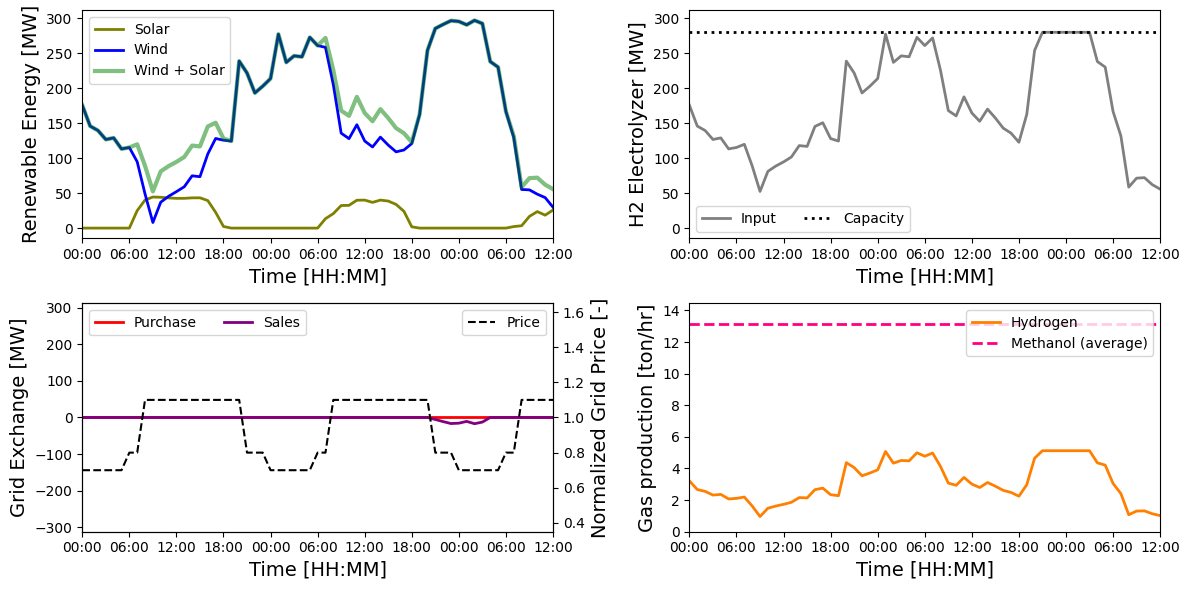

In [79]:
from matplotlib import dates

hour_start = 2016+24*0
n_hours = 61
hour_end = hour_start + n_hours

fig,ax=plt.subplots(2,2,sharex=False)
fig.set_figwidth(12.0)
fig.set_figheight(6.0)

grid_prices = hi_batt.system.dispatch_factors

# Total hydrogen output timeseries (kg-H2/hour)
hydrogen_production_kg_s = hybrid_plant.electrolyzer._system_model.output_streams_kg_s['hydrogen']
hydrogen_production_kg_pr_hr = np.array(hydrogen_production_kg_s*3600)
# Rated/maximum hydrogen production from electrolysis system
max_h2_pr_h2 = np.max(hydrogen_production_kg_pr_hr)
avg_h2_pr_hr = np.mean(hydrogen_production_kg_pr_hr)
#x-values as hours of year
hours_of_year = np.arange(0,len(hydrogen_production_kg_pr_hr),1)
hours_of_year = pd.date_range(start='01/01/2020 00:00:00',freq='1h',periods=8760)
methanol_production_kg_s = hi.system.fuel._system_model.flow_kg_s
methanol_production_kg_pr_hr = np.array(methanol_production_kg_s)*3600
# methanol_production_kg_pr_hr = hydrogen_production_kg_pr_hr*4
max_meoh_pr_hr = np.max(methanol_production_kg_pr_hr)
avg_meoh_pr_hr = np.mean(methanol_production_kg_pr_hr)


ax[0,0].plot(hours_of_year[hour_start:hour_end],batt_solar_plant_power[hour_start:hour_end]/1e3,lw=2,ls='-',c=[.5,.5,0],label='Solar')
ax[0,0].plot(hours_of_year[hour_start:hour_end],batt_wind_plant_power[hour_start:hour_end]/1e3,lw=2,ls='-',c='blue',label='Wind')
# ax[0].plot(hours_of_year[hour_start:hour_end],batt_power[hour_start:hour_end]/1e3,lw=2,ls='-',c=[.5,.5,0],label='Battery')
# ax[0].plot(hours_of_year[hour_start:hour_end],batt_SOC[hour_start:hour_end],lw=2,ls='-',c=[1,.5,0],alpha=0.5,label='Battery SOC')
# ax[0].plot(hours_of_year[hour_start:hour_end],solar_plant_power[hour_start:hour_end]/1e3,lw=2,ls='--',c='orange',label='Solar')
# ax[0].plot(hours_of_year[hour_start:hour_end],wind_plant_power[hour_start:hour_end]/1e3,lw=2,ls='--',c='blue',label='Wind')
ax[0,0].plot(hours_of_year[hour_start:hour_end],renewable_generation_profile[hour_start:hour_end]/1e3,lw=3,alpha=0.5,c='green',label='Wind + Solar')
# ax[0].plot(hours_of_year[hour_start:hour_end],batt_plant_power[hour_start:hour_end]/1e3,lw=2,ls=':',c='green',label='Wind + Solar + Battery')
ax[0,0].set_ylabel('Renewable Energy [MW]',fontsize=14)
ax[0,0].set_xlabel('Time [Month-Day Hour]',fontsize=14)
ax[0,0].set_xlabel('Time [HH:MM]',fontsize=14)
ax[0,0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[0,0].set_xlim(hours_of_year[hour_start],hours_of_year[hour_end-1])
ax[0,0].legend(ncol=1)

# ax[1].plot(hours_of_year[hour_start:hour_end],renewable_generation_profile[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='green',label='Wind + Solar')
# ax[0].plot(hours_of_year[hour_start:hour_end],batt_plant_power[hour_start:hour_end]/1e3,lw=2,c='green',label='Wind + Solar + Battery')
# ax[1,0].plot(hours_of_year[hour_start:hour_end],bought_power[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='red',label='Grid Purchase')
# ax[1,0].plot(hours_of_year[hour_start:hour_end],sold_power[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='purple',label='Grid Sales')
# if 'battery' in hi.system.technologies.keys():
ax[1,0].plot(hours_of_year[hour_start:hour_end],batt_bought[hour_start:hour_end]/1e3,lw=2,c='red',label='Purchase')
ax[1,0].plot(hours_of_year[hour_start:hour_end],batt_sold[hour_start:hour_end]/1e3,lw=2,c='purple',label='Sales')
ax[1,0].set_ylabel('Total Energy [MW]',fontsize=14)
ax[1,0].set_xlabel('Time [Month-Day Hour]',fontsize=14)
ax[1,0].set_xlabel('Time [HH:MM]',fontsize=14)
ax[1,0].set_ylim((-ax[0,0].get_ylim()[1],ax[0,0].get_ylim()[1]))
ax[1,0].legend(ncol=2,loc='upper left')
ax[1,0].set_ylabel('Grid Exchange [MW]',fontsize=14)
ax[1,0].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[1,0].set_xlim(hours_of_year[hour_start],hours_of_year[hour_end-1])
ax2 = ax[1,0].twinx()
ax2.plot(hours_of_year[hour_start:hour_end],grid_prices[hour_start:hour_end],'k--',label='Price')
ax2.set_ylabel('Normalized Grid Price [-]',fontsize=14)
ax2.set_ylim([0.35,1.65])
ax2.legend(loc='upper right')

if 'battery' in hi.system.technologies.keys():
    ax[0,1].plot(hours_of_year[hour_start:hour_end],electrolyzer_extra_profile[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='black',label='Input')
else:
    ax[0,1].plot(hours_of_year[hour_start:hour_end],electrolyzer_profile[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='black',label='Input')
ax[0,1].plot(hours_of_year[hour_start:hour_end],electrolyzer_cap_kw/1000*np.ones(n_hours),lw=2,ls=':',c='black',label='Capacity')
ax[0,1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[0,1].set_xlim(hours_of_year[hour_start],hours_of_year[hour_end-1])
ax[0,1].legend(ncol=2)
ax[0,1].set_ylabel('H2 Electrolyzer [MW]',fontsize=14)
ax[0,1].set_ylim(ax[0,0].get_ylim())
ax[0,1].set_xlabel('Time [Month-Day Hour]',fontsize=14)
ax[0,1].set_xlabel('Time [HH:MM]',fontsize=14)

ax[1,1].plot(hours_of_year[hour_start:hour_end],hydrogen_production_kg_pr_hr[hour_start:hour_end]/1e3,lw=2,c=[1,.5,0],label='Hydrogen')
ax[1,1].plot(hours_of_year[hour_start:hour_end],methanol_production_kg_pr_hr[hour_start:hour_end]/1e3,lw=2,ls="--",c=[1,0,.5],label='Methanol (average)')
# ax[1,1].plot(hours_of_year[hour_start:hour_end],avg_h2_pr_hr/1000*np.ones(n_hours),lw=2,ls='--',c='red',label='Average hydrogen')
ax[1,1].legend(loc='upper right')
ax[1,1].set_ylabel('Gas production [ton/hr]',fontsize=14)
ax[1,1].set_xlabel('Time [Month-Day Hour]',fontsize=14)
ax[1,1].set_xlabel('Time [HH:MM]',fontsize=14)
# ax[1,1].set_xlim((hour_start,hour_end))
ax[1,1].set_ylim((0,max(methanol_production_kg_pr_hr)/1e3*1.1))
ax[1,1].xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax[1,1].set_xlim(hours_of_year[hour_start],hours_of_year[hour_end-1])

# ax[2].plot(hours_of_year[hour_start:hour_end],methanol_production_kg_pr_hr[hour_start:hour_end],lw=2,c='green',label='Methanol Produced')
# ax[2].plot(hours_of_year[hour_start:hour_end],avg_meoh_pr_hr*np.ones(n_hours),lw=2,ls='--',c='red',label='Average methanol')
# ax[2].legend(loc='center right')
# ax[2].set_ylabel('Methanol [kg/hr]',fontsize=14)
# ax[2].set_xlabel('Time [hour of year]',fontsize=14)
# ax[2].set_xlim((hour_start,hour_end-1))

fig.tight_layout()

lb_kg = 2.208
MJ_kg = 20.1
MJ_MMBTU = 1055.

print("Levelized cost of methanol (LCOM), $/kg: {:.3f}".format(hi.system.lc))
for tech in hi.system.lc_breakdown.keys():
    print(tech+': {:.3f}'.format(hi.system.lc_breakdown[tech]))
print("Carbon Intensity (CI), kg/kg-MeOH: {:.3f}".format(hi.system.lca['co2_kg_kg']))
for tech in hi.system.lca_breakdown.keys():
    print(tech+': {:.3f}'.format(hi.system.lca_breakdown[tech]['co2_kg_kg']))